<a href="https://colab.research.google.com/github/karthikjosyula/MSDS_ComputerVision/blob/master/PacMan_DeepQLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Temporal Difference is an online method which relys on intra-episode updates with incremental steps. Incremental update function ("bootstrapping") which features TD error is the core of TD learning. 

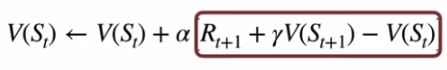

two different time steps t and t+1 in the TD update function : The TD error contains the sum of the return at the next time step and the current estimate for state S t+1, with the value of the previous state S t subtracted from this sum. 
Essentially, we update the estimate of a state with another estimate obtained at a later time-step, in a facsimile gradient descent observed previously for neural networks.


State S, Action A and Reward R :
Let us assume a sequence of S, A, R : S, A, R, S, A, R.......
Due to this cyclic behavior, we can update the value of the previous state as soon as we reach the next state. 
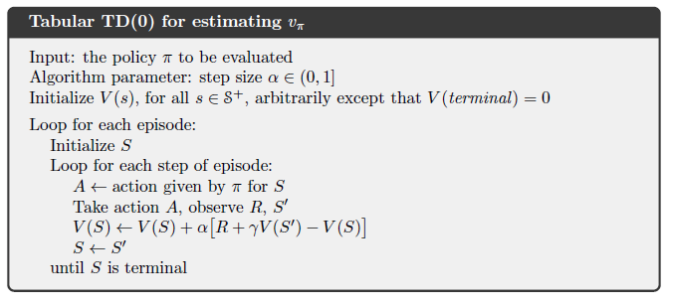

The rapid reactivity of TD or “online” learning approaches makes them suitable for highly dynamic environments, as the values of states and actions is continuously updated throughout time through sets of estimates. Perhaps most notably, TD is the foundation of Q-learning, a more advanced algorithm used to train agents tackling game environments such as those observed in the OpenAI Atari gyms

References :  
1. Adrian Yijie Xu, Dec 22, 2019, Automating Pac-man with Deep Q-learning: An Implementation in Tensorflow, 
https://towardsdatascience.com/automating-pac-man-with-deep-q-learning-an-implementation-in-tensorflow-ca08e9891d9c

2. EXJUSTICE, Dec, 2019, Building an Agent to Play Miss PacMan games using Deep Q Network, in Tensorflow 2.0.
https://github.com/EXJUSTICE/Deep_Q-learning_OpenAI_MissPacman/blob/master/TF2_MsPacMan_GC.ipynb

In [1]:
import numpy as np
import gym
import tensorflow as tf
from tensorflow.contrib.layers import flatten, conv2d, fully_connected
from collections import deque, Counter
import random
from datetime import datetime

In [0]:
color = np.array([210, 164, 74]).mean()
def preprocess_observations(obs):
  # cropping and resizing image
  img = obs[1:176:2, ::2]
  #converting image to grey scale
  img = img.mean(axis=2)
  # Improve image contrast
  img[img==color] = 0
  #normalizing image pixel values to be between -1 to 1
  img = (img - 128)/128 - 1
  return img.reshape(88,80,1)

9
['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


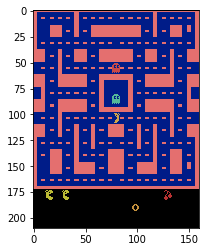

In [3]:
env = gym.make("MsPacman-v0")
n_outputs = env.action_space.n
print(n_outputs)
print(env.env.get_action_meanings())
observation = env.reset()
import tensorflow as tf
import matplotlib.pyplot as plt
for i in range(22):
  if i > 20:
    plt.imshow(observation)
    plt.show()
  observation, _, _, _ = env.step(1)

In [0]:
def q_network(X, name_scope):
  #Initializing the layers
  initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=2.0)
  with tf.compat.v1.variable_scope(name_scope) as scope:
    #intialize the convolutional layers
    layer_1 = conv2d(X, num_outputs = 32, kernel_size = (8,8), stride = 4, padding = 'SAME', weights_initializer = initializer)
    tf.compat.v1.summary.histogram('layer_1', layer_1)

    layer_2 = conv2d(layer_1, num_outputs = 64, kernel_size = (4,4), stride = 2, padding = 'SAME', weights_initializer = initializer)
    tf.compat.v1.summary.histogram('layer_2', layer_2)

    layer_3 = conv2d(layer_2, num_outputs = 64, kernel_size = (3,3), stride = 1, padding = 'SAME', weights_initializer = initializer)
    tf.compat.v1.summary.histogram('layer_3', layer_3)

    flat_l3 = flatten(layer_3)

    fulcon = fully_connected(flat_l3, num_outputs = 128, weights_initializer=initializer)

    tf.compat.v1.summary.histogram('fulcon', fulcon)

    #Adding a final output layer with the 128 inpiuts from fully connected
    output = fully_connected(fulcon, num_outputs = n_outputs, activation_fn = None, weights_initializer = initializer)
    tf.compat.v1.summary.histogram('output', output)
    
    vars = {v.name[len(scope.name):]: v for v in tf.compat.v1.get_collection(key=tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)}
    return vars, output

In [0]:
epsilon = 0.5
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 500000

def epsilon_greedy(action, step):
  p = np.random.random(1).squeeze() #1 dimensional entries are returned using squeeze
  epsilon = max(eps_min, eps_max - (eps_max - eps_min) * step/eps_decay_steps)

  if np.random.rand() < epsilon:
    return np.random.randint(n_outputs)
  else:
    return action 

In [0]:
buffer_len = 20000 
#A deque : This is used for a double ended queue where elements can be added either from head ot tail, a head-tail linkedlist
exp_buffer = deque(maxlen = buffer_len)

In [0]:
def sample_memories(batch_size):
  perm_batch = np.random.permutation(len(exp_buffer))[:batch_size]
  mem = np.array(exp_buffer)[perm_batch]
  return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]


In [0]:
num_episodes = 100
batch_size = 48
input_shape = (None, 88, 80, 1)
learning_rate = 0.001
X_shape = (None, 88, 80, 1)
discount_factor = 0.97
global_step = 0
copy_steps = 100
steps_train = 4
start_steps = 2000

In [0]:
tf.compat.v1.reset_default_graph()
#defining the input X
X = tf.compat.v1.placeholder(tf.float32, shape = X_shape)
#training mode
train_mode = tf.compat.v1.placeholder(tf.bool)
logdir = 'PacmanLogs'

In [10]:
# Building the Q network, to which we feed the above defined X and generate Q values for all the actions in the state
mainQ, mainQ_outputs = q_network(X, 'mainQ')
#Building our target Q network, for policy evaluation
targetQ, targetQ_outputs = q_network(X, 'targetQ')


Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.


In [0]:
X_action = tf.compat.v1.placeholder(tf.int32, shape=(None,))
Q_action = tf.reduce_sum(input_tensor=targetQ_outputs * tf.one_hot(X_action, n_outputs), axis=-1, keepdims=True)

In [0]:
copy_op = [tf.compat.v1.assign(main_name, targetQ[var_name]) for var_name, main_name in mainQ.items()]
copy_target_to_main = tf.group(*copy_op)

In [0]:
# define a placeholder for our output i.e action
y = tf.compat.v1.placeholder(tf.float32, shape=(None,1))

# now we calculate the loss which is the difference between actual value and predicted value
loss = tf.reduce_mean(input_tensor=tf.square(y - Q_action))

# we use adam optimizer for minimizing the loss
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()

loss_summary = tf.compat.v1.summary.scalar('LOSS', loss)
merge_summary = tf.compat.v1.summary.merge_all()
file_writer = tf.compat.v1.summary.FileWriter(logdir, tf.compat.v1.get_default_graph())

In [17]:
with tf.compat.v1.Session() as sess:
    init.run()
    
    # for each episode
    history = []
    for i in range(num_episodes):
        done = False
        obs = env.reset()
        epoch = 0
        episodic_reward = 0
        actions_counter = Counter() 
        episodic_loss = []

        # while the state is not the terminal state
        while not done:

           #env.render()
        
            # get the preprocessed game screen
            obs = preprocess_observations(obs)

            # feed the game screen and get the Q values for each action,  FEED THE NETWORK BY CALLING THE OUTPUT LAYER
            
            actions = mainQ_outputs.eval(feed_dict={X:[obs], train_mode:False})

            # get the action
            action = np.argmax(actions, axis=-1)
            actions_counter[str(action)] += 1 

            # select the action using epsilon greedy policy
            action = epsilon_greedy(action, global_step)
            
            # now perform the action and move to the next state, next_obs, receive reward
            next_obs, reward, done, _ = env.step(action)

            # Store this transistion as an experience in the replay buffer! Quite important
            exp_buffer.append([obs, action, preprocess_observations(next_obs), reward, done])
            
            # After certain steps, we train our Q network with samples from the experience replay buffer
            if global_step % steps_train == 0 and global_step > start_steps:
                
                # sample experience, mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]
                o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(batch_size)

                # states
                o_obs = [x for x in o_obs]

                # next states
                o_next_obs = [x for x in o_next_obs]

                # next actions
                next_act = mainQ_outputs.eval(feed_dict={X:o_next_obs, train_mode:False})


                # discounted reward: these are our Y-values
                y_batch = o_rew + discount_factor * np.max(next_act, axis=-1) * (1-o_done) 

                # merge all summaries and write to the file
                mrg_summary = merge_summary.eval(feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, train_mode:False})
                file_writer.add_summary(mrg_summary, global_step)

                # To calculate the loss, we run the previously defined functions mentioned while feeding inputs
                train_loss, _ = sess.run([loss, training_op], feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, train_mode:True})
                episodic_loss.append(train_loss)
            
            # after some interval we copy our main Q network weights to target Q network
            if (global_step+1) % copy_steps == 0 and global_step > start_steps:
                copy_target_to_main.run()
                
            obs = next_obs
            epoch += 1
            global_step += 1
            episodic_reward += reward
        
        history.append(episodic_reward)
        print('Epochs per episode:', epoch, 'Episode Reward:', episodic_reward,"Episode number:", len(history))

Epochs per episode: 641 Episode Reward: 210.0 Episode number: 1
Epochs per episode: 669 Episode Reward: 220.0 Episode number: 2
Epochs per episode: 631 Episode Reward: 240.0 Episode number: 3
Epochs per episode: 696 Episode Reward: 270.0 Episode number: 4
Epochs per episode: 605 Episode Reward: 230.0 Episode number: 5
Epochs per episode: 684 Episode Reward: 240.0 Episode number: 6
Epochs per episode: 570 Episode Reward: 170.0 Episode number: 7
Epochs per episode: 597 Episode Reward: 190.0 Episode number: 8
Epochs per episode: 687 Episode Reward: 180.0 Episode number: 9
Epochs per episode: 817 Episode Reward: 290.0 Episode number: 10
Epochs per episode: 641 Episode Reward: 230.0 Episode number: 11
Epochs per episode: 686 Episode Reward: 260.0 Episode number: 12
Epochs per episode: 695 Episode Reward: 220.0 Episode number: 13
Epochs per episode: 684 Episode Reward: 180.0 Episode number: 14
Epochs per episode: 522 Episode Reward: 190.0 Episode number: 15
Epochs per episode: 1144 Episode R

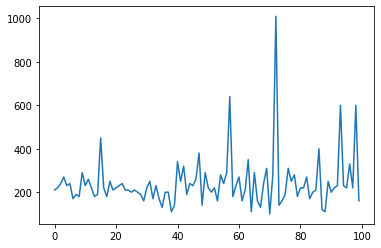

In [18]:
plt.plot(history)
plt.show()

In [19]:
#Visualization cobe for running within Colab

# Install dependencies first for graphics visualization within Colaboratory

#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

     |████████████████████████████████| 593kB 9.7MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 42.0.2
    Uninstalling setuptools-42.0.2:
      Successfully uninstalled setuptools-42.0.2


In [20]:
#To Evaluate model on OpenAI gym, we will record a video via Ipython display
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay


from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [23]:
#Evaluate model on openAi GYM
env = wrap_env(gym.make('MsPacman-v0'))
observation = env.reset()
new_observation = observation

prev_input = None
done = False

with tf.compat.v1.Session() as sess:
    init.run()
    while True:
      if True: 
    
        #set input to network to be difference image
    

        obs = preprocess_observations(observation)

        # feed the game screen and get the Q values for each action
        actions = mainQ_outputs.eval(feed_dict={X:[obs], train_mode:False})

        # get the action
        action = np.argmax(actions, axis=-1)
        actions_counter[str(action)] += 1 

        # select the action using epsilon greedy policy
        action = epsilon_greedy(action, global_step)
        env.render()
        observation = new_observation        
        # now perform the action and move to the next state, next_obs, receive reward
        new_observation, reward, done, _ = env.step(action)

        if done: 
          #observation = env.reset()
          break
      
    env.close()
    show_video()